## 패키지 가져오기

In [1]:
from pykrx import stock
import pandas_datareader.data as web
from talib import BBANDS, RSI, MACD

import pandas as pd
import numpy as np

import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pykrx import stock
from pykrx import bond
import pandas_datareader.data as web
import FinanceDataReader as fdr

from talib import RSI, BBANDS, MACD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
import time
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool, Manager

import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

In [2]:
num_cores = mp.cpu_count()
print(f"사용가능한 코어 수: {num_cores}")

사용가능한 코어 수: 8


In [3]:
# 2023년 3월 1일 기준 KOSPI와 KOSDAQ의 종목 수를 파악
start_date, end_date = "2015-02-11", "2023-03-01"
kospi_tickers = stock.get_market_ticker_list(end_date, market='KOSPI')
kosdaq_tickers = stock.get_market_ticker_list(end_date, market='KOSDAQ')
all_tickers = kospi_tickers + kosdaq_tickers

print("KOSPI 종목 수: ", len(kospi_tickers))
print("KOSDAQ 종목 수: ", len(kosdaq_tickers))
print("전체 종목 수: ", len(all_tickers))

KOSPI 종목 수:  943
KOSDAQ 종목 수:  1615
전체 종목 수:  2558


## 전략 수립 및 구현

KOSPI와 KOSDAQ 있는 주식들을 대상으로 볼린저밴드에서 1-1.5시그마 높으면 매도, 1-1.5시그마 낮으면 매수 하는 전략  
rebalance주기는 5 영업일

In [4]:
# 1주(5 영업일)을 기준으로 rebalancing을 실시
rebalance_period = 5
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index[::rebalance_period]
rebalance_date = pd.to_datetime(rebalance_date, format='%Y-%m-%d')
rebalance_date[:rebalance_period]

DatetimeIndex(['2015-02-11', '2015-02-23', '2015-03-02', '2015-03-09',
               '2015-03-16'],
              dtype='datetime64[ns]', name='날짜', freq=None)

In [5]:
# 이전의 파일을 가져 옴
price_df = pd.read_csv('BBANDS_price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,005965,050110,002700,083590,092460,023760,121550,003520,016710,011210,...,099750,032620,004920,204440,000910,019990,090080,109080,239610,001200
날짜,,,,,,,,,,,,,,,,,,,,,
2015-02-11,18302,1930,1785,4900.0,3580,534,3575.0,1475,10200,139000,...,0.0,2720,1589,1555.0,4235,3801,1167,6010,0.0,2050
2015-02-12,16988,1915,1800,4940.0,3520,534,3590.0,1480,10200,138000,...,0.0,2715,1572,1581.0,4135,3815,1185,6050,0.0,2005
2015-02-13,17306,1925,1820,4950.0,3433,533,3590.0,1505,10550,139000,...,0.0,2730,1574,1640.0,4105,3911,1185,5920,0.0,2020
2015-02-16,16671,2030,1790,4955.0,3427,538,3590.0,1525,10550,138000,...,0.0,2865,1535,1737.0,4055,3963,1198,5910,0.0,2040
2015-02-17,15969,2020,1740,4970.0,3453,550,3560.0,1515,10550,143500,...,0.0,2860,1535,1857.0,4080,3973,1194,5910,0.0,2025


In [6]:
# timeperiod=21, sigma1=1, sigma2=1.5로 설정
def calculate_weights(price_df, timeperiod=21, sigma1=1, sigma2=1.5):
    high_1_df, mid_1_df, low_1_df = price_df.copy(), price_df.copy(), price_df.copy()
    high_2_df, mid_2_df, low_2_df = price_df.copy(), price_df.copy(), price_df.copy()
    for col in price_df.columns:
        high_1, mid_1, low_1 = BBANDS(price_df[col], timeperiod=timeperiod, nbdevup=sigma1, nbdevdn=sigma1, matype=0)
        high_1_df[col], mid_1_df[col], low_1_df[col] = high_1, mid_1, low_1
        
        high_2, mid_2, low_2 = BBANDS(price_df[col], timeperiod=timeperiod, nbdevup=sigma2, nbdevdn=sigma2, matype=0)
        high_2_df[col], mid_2_df[col], low_2_df[col] = high_2, mid_2, low_2
    long_signal = ((price_df < low_1_df) & (price_df > low_2_df)).astype(int)
    short_signal = ((price_df > high_1_df) & (price_df < high_2_df)).astype(int).mul(-1)
    signal = long_signal.add(short_signal)
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        short_signal = (arr == -1).astype(int)
        long_cnt = np.sum(arr == 1)
        short_cnt = np.sum(arr == -1)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        if short_cnt > 0:
            short_signal = -1 * short_signal / short_cnt
        return long_signal.add(short_signal)
    signal = signal.apply(calculate_weights_from_signal, axis=1)
    return signal
weights = calculate_weights(price_df)
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [7]:
# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [8]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,005965,050110,002700,083590,092460,023760,121550,003520,016710,011210,...,099750,032620,004920,204440,000910,019990,090080,109080,239610,001200
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-22,-0.013910,0.026829,0.004739,0.0,-0.006969,0.005487,0.0,0.008902,0.041633,0.050373,...,0.067437,0.014610,-0.034632,0.0,-0.038143,0.000000,0.007347,0.042373,0.004484,0.007380
2023-02-23,-0.010972,-0.077435,0.000000,0.0,-0.014035,-0.001364,0.0,-0.016176,-0.018447,-0.015986,...,0.027076,-0.022400,0.000000,0.0,-0.006897,-0.013388,-0.013776,-0.010163,-0.022321,0.000000
2023-02-24,-0.015848,-0.015448,0.000000,0.0,-0.016014,-0.006831,0.0,-0.032885,0.012529,-0.014440,...,-0.047452,-0.006547,-0.017040,0.0,-0.022569,0.003132,-0.011504,0.003422,0.018265,-0.012821
2023-02-27,-0.001610,0.034519,0.009434,0.0,0.005425,0.005502,0.0,0.001546,-0.017015,0.023810,...,0.068266,0.034596,-0.001825,0.0,0.003552,0.009365,0.008313,0.034106,0.008969,0.000000
2023-02-28,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,-0.002796
2023-02-22,-0.001647
2023-02-23,-0.000944


In [10]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,-0.559099
2023-02-22,-0.559825
2023-02-23,-0.560240


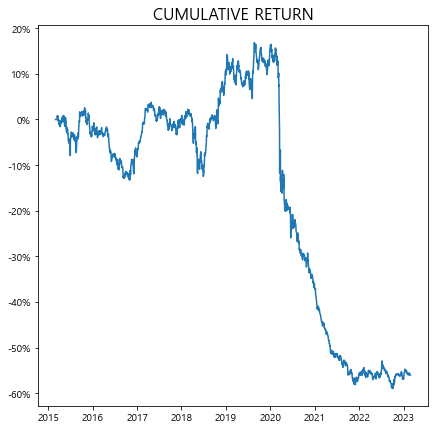

In [11]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))